# Integracion y trayectorias

# Caida de un cuerpo en un plano inclinado


In [2]:
from pylab import *
%matplotlib inline

In [3]:
#Método de integración 4to órden, como argumentos tomará elángulo del plano inclinado
def Runge_Kuta4(ec,p_ini,x,args = " ",h=0.01):
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args== " ":
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)         
    return tiempos,sol

In [4]:
#Método para encontrar racices
def raiz_bip(func,x_i,x_d,err=1e-8):
    raiz = 0.5*(x_i+x_d)
    y_i,y_d = func(x_i),func(x_d)
    n = 0
    while abs(y_d)>=err:
        y_m = func(raiz)
        if y_m == 0.:
            break
        if y_m*y_i < 0:
            x_d = raiz
        else:
            x_i = raiz
        raiz = 0.5*(x_i+x_d)
        y_i,y_d = func(x_i),func(x_d)
        n += 1
        print n,"\t",raiz
    return raiz

Haremos una rotación del sistema de coordenadas normal de modo que el plano inclinado sea el eje x y la fuerza gravitacinal esté inclinada, luego de calcular los puntos en este sistema de referencia, haremos una rotación a cada uno de ellos para encontrarlos en el sistema natural

In [5]:
#ecuación de movimiento de caída libre, la modificamos en las aceleraciones
def e_mov(r_v,t,fric = [0,0],g=9.8,m=1):
    u = sqrt(r_v[2]**2 + r_v[3]**2)
    dx = r_v[2]
    dy = r_v[3]
    if fric[0] == 0:
        dvx,dvy = (g/m)*sin(fric[1]) ,-(g/m)*cos(fric[1])
        #print "No use un modelo de friccion"
    else:
        dvx = (g/m)*sin(fric[1]) - fric[0]([r_v[2],r_v[3]])[0]
        dvy = -(g/m)*cos(fric[1]) - fric[0]([r_v[2],r_v[3]])[1]
        #print "Use un modelo de friccion"
    return array([dx,dy,dvx,dvy])

In [6]:
def sin_fric(v,gamma=1):
    return 0
def fric_v(v,gamma=1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

def fric_v2(v,gamma=1):
    norm_v = sqrt(v[0]**2 + v[1]**2)
    f_x = gamma*norm_v*v[0]
    f_y = gamma*norm_v*v[1]
    return array([f_x,f_y])

In [7]:
#Esta función 
def rebote(r_i,mi_dt,fric,alfa)  :
    dt_busqueda = mi_dt
    y_izq = r_i
    t,sol = Runge_Kuta4(e_mov,r_i,[0,dt_busqueda],[fric,alfa])
    y_med = sol[-1,:]
    while abs(y_izq[1]) > 1e-5:
        if y_izq[1]*y_med[1] < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = Runge_Kuta4(e_mov,reinicio,[0,dt_busqueda],[fric,alfa])
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])    
    return y_izq

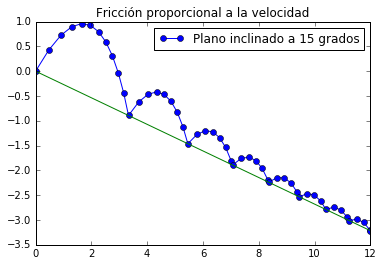

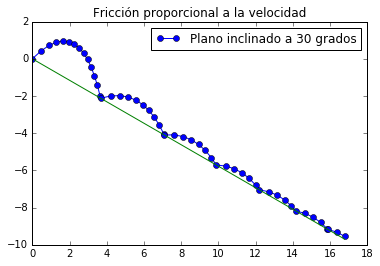

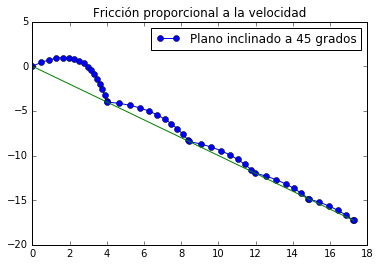

In [8]:
#####Fricción proporcional a la velocidad
for a in [15,30,45]:
    alfa = a*(pi/180)
    inicio = [0,0,5,5]
    fric = fric_v
    inicio2 = [0,0,inicio[2]*cos(alfa)-inicio[3]*sin(alfa),inicio[2]*sin(alfa)+inicio[3]*cos(alfa)]
    N = 50
    trayectoria = zeros((N,len(inicio2)))
    trayectoria_real = zeros((N,2))
    mi_dt = .1
    trayectoria[0,:] = array(inicio2)
    for i in range(N-1):
        t,sol_dt = Runge_Kuta4(e_mov,trayectoria[i,:],[0,mi_dt],[fric,alfa])
        if sol_dt[-1,:][1] < 0:
            punto = rebote(trayectoria[i,:],mi_dt,fric,alfa)
            trayectoria[i+1,:] = punto
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]
    #Definamos la matriz de rotación como:
    R = array([[cos(alfa),sin(alfa)],[-sin(alfa),cos(alfa)]])
    for s in range(len(trayectoria[:,0])):
        trayectoria_real[s,:]=dot(R,array([trayectoria[s,0],trayectoria[s,1]]))
        
    plot(trayectoria_real[:,0],trayectoria_real[:,1],'o-', label ='Plano inclinado a %s grados'%a)
    
    plot(trayectoria_real[:,0],-tan(alfa)*trayectoria_real[:,0])
    title(u'Fricción proporcional a la velocidad')
    legend()
    show()


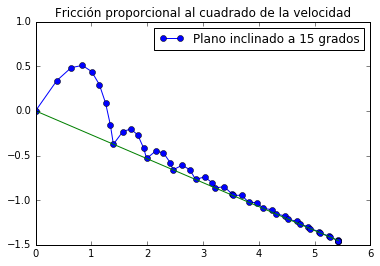

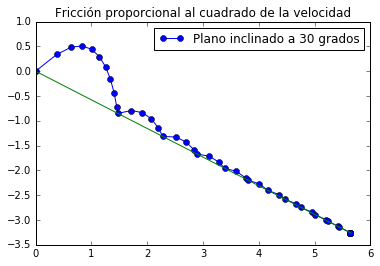

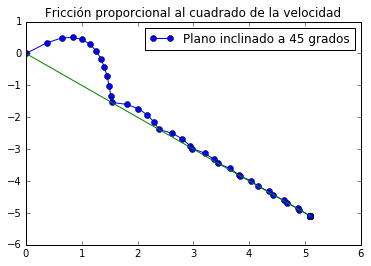

In [9]:
#####Fricción proporcional al cuadrado de la velocidad
for a in [15,30,45]:
    alfa = a*(pi/180)
    inicio = [0,0,5,5]
    fric = fric_v2
    inicio2 = [0,0,inicio[2]*cos(alfa)-inicio[3]*sin(alfa),inicio[2]*sin(alfa)+inicio[3]*cos(alfa)]
    N = 50
    trayectoria = zeros((N,len(inicio2)))
    trayectoria_real = zeros((N,2))
    mi_dt = .1
    trayectoria[0,:] = array(inicio2)
    for i in range(N-1):
        t,sol_dt = Runge_Kuta4(e_mov,trayectoria[i,:],[0,mi_dt],[fric,alfa])
        if sol_dt[-1,:][1] < 0:
            punto = rebote(trayectoria[i,:],mi_dt,fric,alfa)
            trayectoria[i+1,:] = punto
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]
    #Definamos la matriz de rotación como:
    R = array([[cos(alfa),sin(alfa)],[-sin(alfa),cos(alfa)]])
    for s in range(len(trayectoria[:,0])):
        trayectoria_real[s,:]=dot(R,array([trayectoria[s,0],trayectoria[s,1]]))

    plot(trayectoria_real[:,0],trayectoria_real[:,1],'o-', label ='Plano inclinado a %s grados'%a)
    title(u'Fricción proporcional al cuadrado de la velocidad')
    legend()
    plot(trayectoria_real[:,0],-tan(alfa)*trayectoria_real[:,0])
    show()


Escogamos $v_{0x}$ tal que $tg(\frac{v_{0x}}{v_{0y}})^{-1} > alfa $

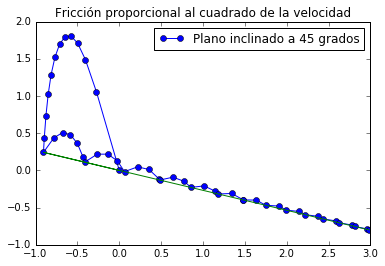

In [10]:
alfa = 15*(pi/180)
inicio = [0,0,-5,20]
fric = fric_v2
inicio2 = [0,0,inicio[2]*cos(alfa)-inicio[3]*sin(alfa),inicio[2]*sin(alfa)+inicio[3]*cos(alfa)]
N = 50
trayectoria = zeros((N,len(inicio2)))
trayectoria_real = zeros((N,2))
mi_dt = .1
trayectoria[0,:] = array(inicio2)
for i in range(N-1):
    t,sol_dt = Runge_Kuta4(e_mov,trayectoria[i,:],[0,mi_dt],[fric,alfa])
    if sol_dt[-1,:][1] < 0:
        punto = rebote(trayectoria[i,:],mi_dt,fric,alfa)
        trayectoria[i+1,:] = punto
    else:
        trayectoria[i+1,:] = sol_dt[-1,:]
#Definamos la matriz de rotación como:
R = array([[cos(alfa),sin(alfa)],[-sin(alfa),cos(alfa)]])
for s in range(len(trayectoria[:,0])):
    trayectoria_real[s,:]=dot(R,array([trayectoria[s,0],trayectoria[s,1]]))

plot(trayectoria_real[:,0],trayectoria_real[:,1],'o-', label ='Plano inclinado a %s grados'%a)
title(u'Fricción proporcional al cuadrado de la velocidad')
legend()
plot(trayectoria_real[:,0],-tan(alfa)*trayectoria_real[:,0])
show()

Sube y luego se regresa

# Raices de una funcion

In [323]:
def raiz_bip(func,x_i,x_d,err=1e-7,y = " "):
    raiz = 0.5*(x_i+x_d)
    if y == " ":
        y_i,y_d = func(x_i),func(x_d)
        while abs(raiz - x_d) >= err and abs(y_i-y_d) >= err:
            y_m = func(raiz)
            if y_m == 0:
                break
            if y_m*y_i < 0:
                x_d = raiz
            else:
                x_i = raiz
            raiz =  0.5*(x_i+x_d)
            y_i,y_d = func(x_i),func(x_d)
    else:
        y_i,y_d = func(x_i,y),func(x_d,y)
        while abs(raiz - x_d) >= err and abs(y_i-y_d) >= err:
            y_m = func(raiz,y)
            if y_m == 0:
                break
            if y_m*y_i < 0:
                x_d = raiz
            else:
                x_i = raiz
            raiz =  0.5*(x_i+x_d)
            y_i,y_d = func(x_i,y),func(x_d,y)
    return raiz

In [444]:
#Esta función sondea un intetvalo I=[a,b] para encontrar raices, lo divide en N pedazos 
#y busca en cada uno si hay cambio de signo, si hay aplica el método de biparticion a ese intervalo
#Con ayuda del parámetro adicional y puede sondear a lo largo de una recta y constante para buscar raices
#en funciones de dos variables
def raices_osc(f,I,N,y = " "):
    Y = linspace(I[0],I[1],N)
    #Define una variable grande para que quepan las mas raices posibles, si se llena se redimensiona
    raices_o = [0]*10
    #este es el contador que nos dirá si está llena nuestra variable de raices
    m = 0
    #Permite decidir entre colocar argumentos o no
    if y == " ":
        for i in range(len(Y)-1):
            #Si  hay cambio de signo aplica el método de bipartición
            if f(Y[i])*f(Y[i+1]) < 0:
                raices_o[m] = raiz_bip(f,Y[i],Y[i+1],1e-7)
                #aumenta el contador para saber cuanto espacio queda
                m = m+1
                #Si el espacio se acaba hace mas grande la lista
                if m > (len(raices_o)-1):
                    raices_o = raices_o +1*[0]
        #Como a priori no sabemos cuantas raices encontraremos por lo general sobraran algunos ceros en la
        #lista donde se almacenan las raices, este algoritmo los eleimina
        s = 0
        raices = [raices_o[0]]
        #como las raices se encuentran secuencialmente  hay que preguntarle si el siguiente número es raiz
        #y si ese número cumple con ser mayor al actual
        #así va llenando una nueva lista que ya no tiene ceros extra y la entrega a la salida
        while (raices_o[s] < raices_o[s+1]) and (abs(f(raices_o[s+1])) < 1e-6):
            s = s+1
            raices = raices + [raices_o[s]]                    
            
    else:
        for i in range(len(Y)-1):
            if f(Y[i],y)*f(Y[i+1],y) < 0:
                raices_o[m] = raiz_bip(f,Y[i],Y[i+1],1e-7,y)
                m = m+1
                if m > (len(raices_o)-1):
                    raices_o = raices_o +1*[0]
        s = 0
        raices = [raices_o[0]]
        while (raices_o[s] < raices_o[s+1]) and ( abs(f(raices_o[s+1],y)) < 1e-6):
                s = s+1
                raices = raices + [raices_o[s]]
            

    return raices

In [445]:
def funcion2(x):
    return cos(x) + (6./5.)*sin(x*x)

In [446]:
F = raices_osc(funcion2,[0,2*3.1416],10000)

    
for i in range(len(F)):
    print "La raiz #", i+1, "es:", F[i]
print ""
print ""
print F

La raiz # 1 es: 1.73377184084
La raiz # 2 es: 2.66809074941
La raiz # 3 es: 2.91173606964
La raiz # 4 es: 3.65748888653
La raiz # 5 es: 3.87851656675
La raiz # 6 es: 4.37378840566
La raiz # 7 es: 4.68723684187
La raiz # 8 es: 4.99020604308
La raiz # 9 es: 5.36717867613
La raiz # 10 es: 5.54540053695
La raiz # 11 es: 5.95538720155
La raiz # 12 es: 6.06215490731


[1.7337718408364271, 2.6680907494069719, 2.91173606964212, 3.6574888865253716, 3.8785165667543313, 4.3737884056569705, 4.6872368418677812, 4.9902060430847772, 5.3671786761293312, 5.5454005369482253, 5.9553872015521865, 6.0621549073071357]


# Raices de una funcion multivariada

In [493]:
def funcion3(x,y):
    return 2.*exp(-(x+1.)*(x+1.))*(exp(-(y+2.)*(y+2.))+exp(-(y-2.)*(y-2.)))+6.*x*(x*x+y*y)*exp(-x*x-y*y)-1


In [490]:
#esta función sondea el producto cartesiano de los intervalos Ix=[a,b] e Iy=[c,d] dividiendo cada 
#uno en Nx y Ny partes
def raices_x_y(f,Ix,Iy,Nx,Ny):
    L = linspace(Ix[0],Ix[1],Nx)
    M = linspace(Iy[0],Iy[1],Ny)
    raices = zeros([len(L)*len(M),2])
    c = 0
    #cambia la y sobre la cual buscamos raices
    for i in range(len(M)):
        #busca las raices a y=M[i] constante
        F = raices_osc(f,[Ix[0],Ix[1]],Nx,M[i])
        if len(F) != 1 or f(Ix[0],M[i]) == 0 :
            for n in range(len(F)):
                raices[c+n,0]=F[n]
                raices[c+n,1]=M[i]
            c = c + len(F)
    #este pedazo sigue la misma lógica que el pedazo de la funci{on anterior, es para eliminar
    #ceros extra
    s = 0
    while (raices[s,1] <= raices[s+1,1]) and (abs(f(raices[s+1,0],raices[s+1,1])) < 1e-6):
            s = s+1
    raicesf = zeros([s,2])
    for l in range(s):
        raicesf[l,0] = raices[l,0]
        raicesf[l,1] = raices[l,1]
    #Al final el programa entrega un arreglo que tiene todas las raices encontradas
    return raicesf

In [491]:
B = raices_x_y(funcion3,[-4,4],[-4,4],100,100)

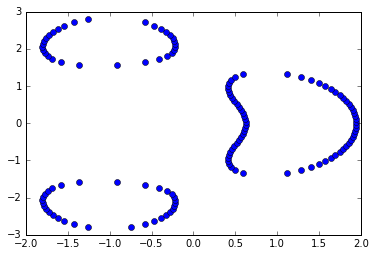

In [492]:
plot(B[:,0],B[:,1],'o')